# NLP Application - Restaurant Review Analysis 👨‍🍳
## By BROSSEAU Alexandre & COGORDAN Alexandre

In [1]:
# Our imports

import nltk
import requests
import time
import pandas as pd
import os
import re
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import streamlit as st
import torch
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_hub as hub
import nlpaug.augmenter.word as naw
import random
import xgboost as xgb
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from langchain import PromptTemplate, LLMChain
from dotenv import find_dotenv, load_dotenv
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorboard.plugins import projector
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model, Sequential
from scipy.spatial.distance import euclidean, cosine
from sklearn.ensemble import RandomForestClassifier
from nlpaug.util import Action
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# We set a random seed
np.random.seed(42)

# We load our environment variables - API, HuggingFace, OPENAI keys
load_dotenv()

/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("best_of")
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydan

True

## Loading our dataset

com1: We're re-using the csv files that had previously ran analysis so that we avoid running the calculations multiple times and waste time on computational power.

In [2]:
df = pd.read_csv('yelp_reviews.csv')

# We drop duplicates and null values
df.drop_duplicates(inplace=True)
df.dropna(subset=['text', 'rating', 'location'], inplace=True)

## Pre-processing

In [3]:
# Translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].astype(str)

# Check if text contains Chinese characters
def contains_chinese(text):
    return bool(re.search('[\u4e00-\u9fff]', text))

# Translation function (from Chinese to English)
def translate_text(text):
    if contains_chinese(text):
        return translator(text)[0]['translation_text']
    else:
        return text
    
# We remove special characters/punctuation whilst keeping characters with accents since their meaning is important in French restaurants reviews
def remove_special_characters(text):
    pattern = r"[^\w\séèàçêôœ]"
    
    # We substitute matched characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text
    
# Lemmatisation & Tokenisation function
def tokenisation(reviews, allowed_postags=["NOUN", "ADJ", "VERBS", "ADV"]):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    reviews_out = []
    tokens = []

    for review in reviews:
        doc = nlp(review) 
        reviews_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]))
    
    for text in reviews_out:
        new = gensim.utils.simple_preprocess(text, deacc=False) # We do not remove the accent marks because we deem them important for French restaurants reviews
        tokens.append(new)

    return tokens

# Preprocessing function - which regroups all of the previous steps too
def preprocessing(text):
    # Translation
    translated_text = translate_text(str(text))

    # We remove special characters/punctuation
    corrected_text = remove_special_characters(translated_text)

    # Corrected spelling on lower case text
    cleaned_text = str(TextBlob(corrected_text.lower()).correct())

    return cleaned_text

# Apply preprocessing and tokenisation
df['cleaned_text'] = df['text'].apply(preprocessing)
df['tokens'] = tokenisation(df['cleaned_text'])

We decided to oversample to achieve balance, the solution will be shown later in the code

In [4]:
rating_mapping = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
df['rating'] = df['rating'].map(rating_mapping)
df['rating'].value_counts(normalize=True)

rating
2    0.799414
1    0.112738
0    0.087848
Name: proportion, dtype: float64

## We review the most frequent words 

com2: This allows us to get an understanding of the most frequent words found in reviews for each restaurant. This gives a broad introduction to the feeling people get in a specific restaurant.

In [5]:
review_frequent_words = {}

def get_frequency(restaurant_id):

    # Word Frequency Analysis
    all_words = [word for tokens in df[df['restaurant_id'] == restaurant_id]['tokens'] for word in tokens]
    word_freq = Counter(all_words)

    # Sort the word frequency in descending order
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

    # N-gram Analysis
    bigrams = ngrams(all_words, 2)
    bigram_freq = Counter(bigrams)

    # Sort the bigram frequency in descending order
    bigram_freq = dict(sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True))

    # Tri-gram Analysis
    trigrams = ngrams(all_words, 3)
    trigram_freq = Counter(trigrams)

    # Sort the trigram frequency in descending order
    trigram_freq = dict(sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True))

    return [word_freq, bigram_freq, trigram_freq]

# We create a dictionary with the restaurant_id as key and the frequency of words, bigrams and trigrams as values
for restaurant_id in df['restaurant_id']:
    review_frequent_words[restaurant_id] = get_frequency(restaurant_id)

review_frequent_words_df = pd.DataFrame.from_dict(review_frequent_words, orient='index', columns=['word_freq', 'bigram_freq', 'trigram_freq'])
review_frequent_words_df

,word_freq,bigram_freq,trigram_freq
GBTPC53ZrG1ZBY3DT8Mbcw,"{'time': 2, 'still': 2, 'date': 1, 'partner': ...","{('date', 'partner'): 1, ('partner', 'pate'): ...","{('date', 'partner', 'pate'): 1, ('partner', '..."
-Tskf8WK17rb3ZfeFuRSWA,"{'banana': 1, 'foster': 1, 'review': 1, 'even'...","{('banana', 'foster'): 1, ('foster', 'review')...","{('banana', 'foster', 'review'): 1, ('foster',..."
I0I2mkCOPTYVSLpc8A8VVw,"{'restaurant': 2, 'food': 2, 'hotel': 2, 'lite...","{('literally', 'french'): 1, ('french', 'resta...","{('literally', 'french', 'restaurant'): 1, ('f..."
2jX71Q0_nAD9X5An84fs_Q,"{'restaurant': 2, 'food': 2, 'lovely': 1, 'sta...","{('restaurant', 'lovely'): 1, ('lovely', 'staf...","{('restaurant', 'lovely', 'staff'): 1, ('lovel..."
uKXw5zfNtNw_eJW2arHLFw,"{'place': 2, 'list': 1, 'year': 1, 'finally': ...","{('place', 'list'): 1, ('list', 'year'): 1, ('...","{('place', 'list', 'year'): 1, ('list', 'year'..."
...,...,...,...
-QtB-fGXYKdaEQySVO28wg,"{'recent': 2, 'well': 2, 'awesome': 1, 'vera':...","{('awesome', 'vera'): 1, ('vera', 'pattern'): ...","{('awesome', 'vera', 'pattern'): 1, ('vera', '..."
uyaz8BMIp2n7lhSpjZ8quA,"{'dining': 2, 'special': 2, 'occasion': 2, 'la...","{('special', 'occasion'): 2, ('last', 'night')...","{('amazing', 'dining', 'experience'): 1, ('din..."
GRZpClfFf3otLO2ridn5iA,"{'place': 2, 'rascal': 2, 'old': 2, 'never': 2...","{('first', 'time'): 2, ('place', 'smell'): 1, ...","{('place', 'smell', 'childhood'): 1, ('smell',..."
B2-pidnIEJcI4-sy97BJww,"{'service': 2, 'food': 2, 'urinary': 1, 'journ...","{('urinary', 'journey'): 1, ('journey', 'right...","{('urinary', 'journey', 'right'): 1, ('journey..."


## Topic Modelling

com3: We regroup similar words together to form topics. This will be useful for our users who will be able to choose the topic that is more important to them. We'll then choose the reviews that have the specific tokens found in the topics chosen to give the user the restaurant with the criteria they wish to have.

In [6]:
# We convert the tokens into tuples where we'll have the word index (its placement on the map) and its frequency
id2word = corpora.Dictionary(df['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

# We create the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# We visualise the topics
pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=10)
pyLDAvis.display(vis)

/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


com4: The visualization is well-constructed. It provides us with a high-level overview of the topics and allows for an interactive exploration of the terms that define each topic.
The map shows a good separation of topics which suggests distinct themes with salient terms captured by the model.
The presence of both common and specific terms within the topics suggests the model is effectively capturing the range of discourse present in the data which we usually find in reviews.
The distance between each theme suggests that the themes are diverse yet distinct.

## Using themes

com5: We proceed to create a dictionary to rename the topics based on the top 5 keywords of each topic. This will allow us to classify the review into themes that the user will be able to use. This will work by looking to see if the reviews contains the corresponding keywords of the topics. 

In [7]:
def get_topic_distribution(lda_model, bow):
    return lda_model.get_document_topics(bow, minimum_probability=0)

# We get the topic distribution for each review
df['topic_distribution'] = [get_topic_distribution(lda_model, corpus[i]) for i in range(len(df))]

# We get the top topics for each review
def get_top_topics(topic_distribution, num_topics=5):
    # Sort the topics by probability and select the top ones
    return sorted(topic_distribution, key=lambda x: x[1], reverse=True)[:num_topics]

df['top_topics'] = df['topic_distribution'].apply(lambda x: get_top_topics(x, 11 - 1))

# We label the topics
def label_topics(topic_list, lda_model):
    labels = []
    for topic_id, _ in topic_list:
        # Get the top words in the topic
        words = lda_model.show_topic(topic_id, 10)
        # Create a label (e.g., by joining the top words)
        label = [word for word, prob in words]
        labels.append(label)
    return labels

# We create a dictionary with the labels as keys and the words as values
def topicise(labels, label_dict):
    topics = []

    for topic_list in labels:
        for key, value in label_dict.items():
            if set(value).issubset(set(topic_list)):
                topics.append(key)

    return topics

# We label the topics
label_dict = {
    'Unforgettable Moments': ['last', 'friend', 'excellent', 'staff', 'year'],
    'Dining Atmosphere': ['dinner', 'french', 'place', 'really', 'good'],
    'Food & Service': ['service', 'food', 'experience', 'dining', 'absence'],
    'Culinary Selection': ['review', 'branch', 'dish', 'never', 'door'],
    'Ambience & Celebrations': ['first', 'time', 'birthday', 'give', 'wife'],
    'Comfort & Class': ['beautiful', 'table', 'life', 'class', 'implacable'],
    'Quality of establishment': ['friendly', 'course', 'small', 'establishment', 'tartar'],
    'Venue & Occasions': ['wonderful', 'day', 'new', 'holiday', 'bartender'],
    'Special Moments': ['birthday', 'friend', 'wife', 'inside', 'give'],
    'Dating & Love': ['family', 'moment', 'intimate', 'warm', 'heart']
}

df['top_topic_labels'] = df['top_topics'].apply(lambda x: label_topics(x, lda_model))
df['topics'] = df['top_topic_labels'].apply(lambda x: topicise(x, label_dict))
df.drop(columns=['topic_distribution', 'top_topics'], inplace=True)

## BERT - Sentiment analysis & Generation

com6: We've decided to go with this: BERT for Text Classification: Given its context-aware nature and superior performance in understanding nuances, BERT is generally the better choice for text classification.
Word2Vec for Semantic Search: For semantic search tasks, Word2Vec's efficiency and effectiveness in finding similar words make it a strong choice.
We also used BERT in our advantage to generate new reviews and fix the imbalance issue we have with our reviews. From our experiments, we've realised that the training process for our word2vec and td-idf model was skewed. This was caused by the large amount of initial positive reviews compared to the initial neutral and negative reviews. Therefore, we've used generation by using a context augmenter on our previously inserted negative and neutral reviews. This deeply improved the cohesion of our models.

In [8]:
# Load the tokenizer and model
tokeniser = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Sentiment analysis function
def sentiment_score(review):
    tokens = tokeniser.encode(review, return_tensors="pt")
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

# Application to the DataFrame
df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x) - 1)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


com7: We've carried out this sentiment analysis by using the twitter-roberta-base-sentiment model. This will ouput values as such:
* 1: negative sentiment
* 2: neutral sentiment
* 3: positive sentiment 

In [9]:
# We're going to incrase the number of negative and neutral reviews to balance the dataset using text-augmentation and back-translation.
context_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_p=0.2)

# Translation pipelines for back-translation
english_to_french = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")
french_to_english = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

# Back-translation function
def back_translate(text):
    # Translate to French
    french_text = english_to_french(text)[0]['translation_text']
    # Translate back to English
    back_translated_text = french_to_english(french_text)[0]['translation_text']
    return back_translated_text

def generate_new_reviews(text):
    # text = back_translate(text)
    text = context_aug.augment(text)
    # text = back_translate(text)
    
    return text

com8: Back-translation is another way to rephrase texts without losing context. However, after experimenting, we realised that the texts were too similar if back-translation was used by itself and it strayed too far from its context if it was used in complement to context augmentation. Therefore, we judged that using context augmented generation of our reviews gave us sufficient results to generate new reviews with it by itself.

In [10]:
# We create a function to push the new reviews to the DataFrame

def push_new_reviews(df):
    # We record the original data types to conserve them between concatenations
    original_dtypes = df.dtypes

    # We create a DataFrame for each sentiment
    sentiment_1_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[1]]
    sentiment_2_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[2]]
    
    # We generate new reviews for each sentiment

    # The sentiment with the most second amount of reviews (which was NEUTRAL in our case)
    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[1] - 1):
        random_row = random.choice(sentiment_1_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)

    # The sentiment with the least amount of reviews (which was NEGATIVE in our case)
    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[2] - 1):
        random_row = random.choice(sentiment_2_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)
        
    return df

generated_df = push_new_reviews(df)
df = generated_df.sample(frac=1, random_state=42).reset_index(drop=True)

com9: We use the Phrases algorithm to detect common phrases (bigrams and trigrams) from a stream of sentences. The Phrases model is then used to transform sentences by replacing common phrases with a common token, e.g. 'new','york','times' -> 'new_york_times'.

In [11]:
# Phrases alogrithm - bigrams and trigrams 

# We've set the parameters to 3 and 5 respectively for the minimum count and threshold because we want to keep the bigrams and trigrams that appear at least 3 times and have a score of at least 5. This was done after several iterations of the model and by looking to see if the grouped tokens made sense in a restaurant review context.

min_count = 3
threshold = 5

phrases = Phrases(df['tokens'], min_count=min_count, threshold=threshold)
phraser = Phraser(phrases)

df['bigrams'] = phraser[ df['tokens']]
df['trigrams'] = phraser[df['bigrams']]

In [12]:
df.to_csv('yelp_reviews.csv', index=False)

## Our own Word2vec model

### Training

com10: We train our Word2Vec model with the tokens from our reviews. We didn't end up using the bigrams and trigrams because they didn't improve the model's performance.

In [13]:
vector_size = 300 # Dimensionality of the word vectors
window = 8 # Maximum distance between the current and predicted word within a sentence
min_count = 10 # Ignores all words with total frequency lower than this
workers = 8 # Number of CPU cores
learning_rate = 0.001 # Initial learning rate
sample = 1e-3 # Downsample setting for frequent words

# Training the model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=1, alpha=learning_rate, sample=sample, epochs=20)

# Save the model
word2vec_model.save("word2vec.model")

In [14]:
model = Word2Vec.load("word2vec.model")

def vectorize_model(sent, model):
    vector_size = model.vector_size
    model_res = np.zeros(vector_size)
    ctr = 0
    for word in sent:
        if word in model.wv.key_to_index:
            ctr += 1
            model_res += model.wv[word]
    if ctr > 0:
        model_res = model_res / ctr
    return model_res

df['vectors'] = df['tokens'].apply(lambda x: vectorize_model(x, model))

X = df['vectors'].to_list()
y = df['sentiment'].to_list()

test_size = 0.3
stratify_value = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=stratify_value, random_state=42)

# Create a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC(kernel='linear')),
    ("Random Forest", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier())
]

# Loop through the classifiers and test each one
for name, classifier in classifiers:
    print(f"Testing {name} Classifier:")
    classifier.fit(X_train, y_train)  # We train the classifier on our data
    y_pred = classifier.predict(X_test)  # We make predictions on the test data

    # We evaluate the classifiers' performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

Testing Logistic Regression Classifier:
Accuracy: 0.4915

Testing SVM Classifier:
Accuracy: 0.3333

Testing Random Forest Classifier:
Accuracy: 0.9872

Testing K-Nearest Neighbors Classifier:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.8269

Testing Decision Tree Classifier:
Accuracy: 0.8996



com11: We can see that the best model in our use case is the random forest classifier in terms of accuracy

com12: We also apply other ways to evaluate our model - such as the F1 score, ROC curve and AUC score. We use the cross-validation method to evaluate the model's performance on unseen data and we use the grid search method to find the best parameters for our model.

### Confusion Matrix

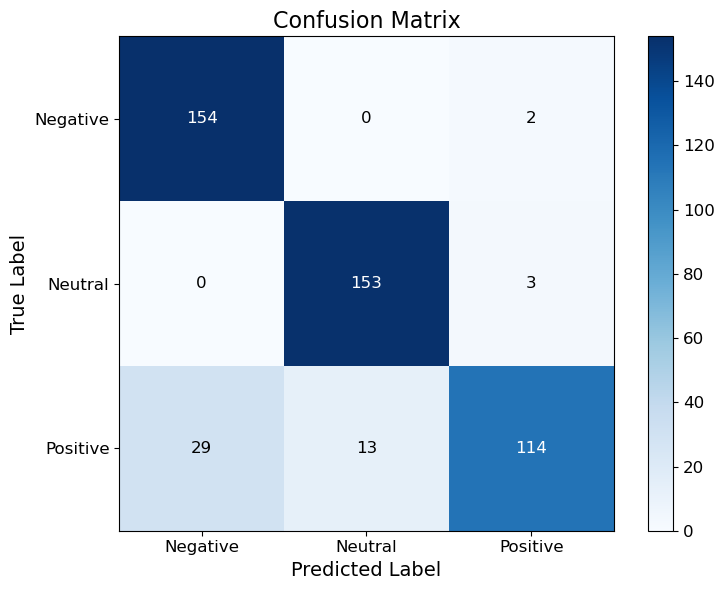

In [15]:
confusion = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap='Blues')

# Adding colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)

# Adding title and axis labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Customising tick labels
tick_labels = ['Negative', 'Neutral', 'Positive']
plt.xticks([0, 1, 2], tick_labels, fontsize=12)
plt.yticks([0, 1, 2], tick_labels, fontsize=12)

# Adding text annotations
thresh = confusion.max() / 2
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > thresh else "black",
                 fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()

com13: We can see fro the matrix that the model demonstrates strong sentiment classification performance with particularly high accuracy for Negative and Neutral reviews. However, there may be room for improvement in distinguishing between Positive reviews and the other categories, we thought that this issue would be fixed by increasing the number of reviews.

### ROC Curve

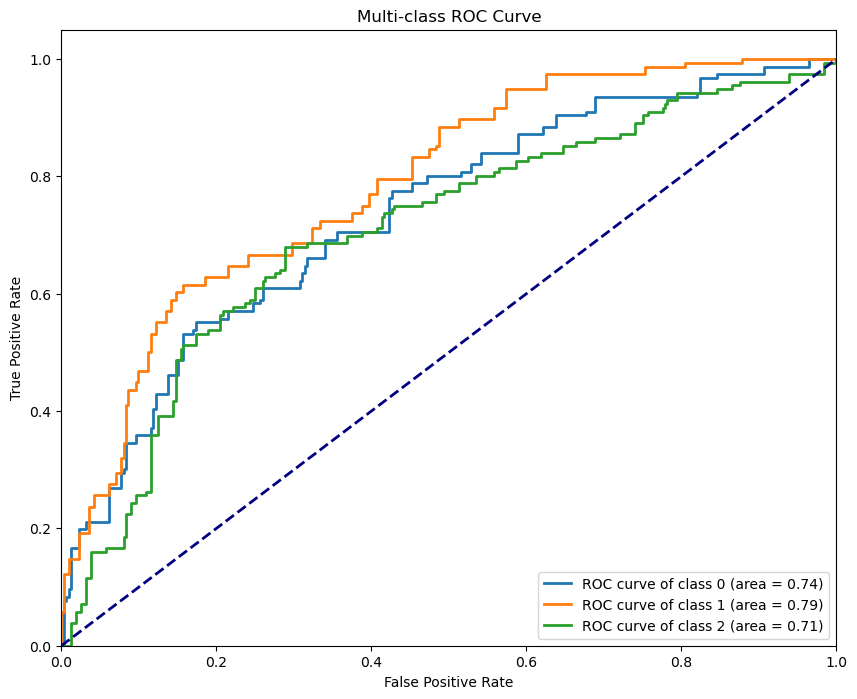

In [16]:
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Initialize classifier - using Logistic Regression as an example
# You can replace this with any classifier of your choice
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train, y_train_binarized)

# Predict probabilities
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each individual ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

com14: After analysing this ROC model, it seems that it is performing fairly well, with particularly strong performance on the Neutral class.

## Embedding visualisation

### Using Matplotlib

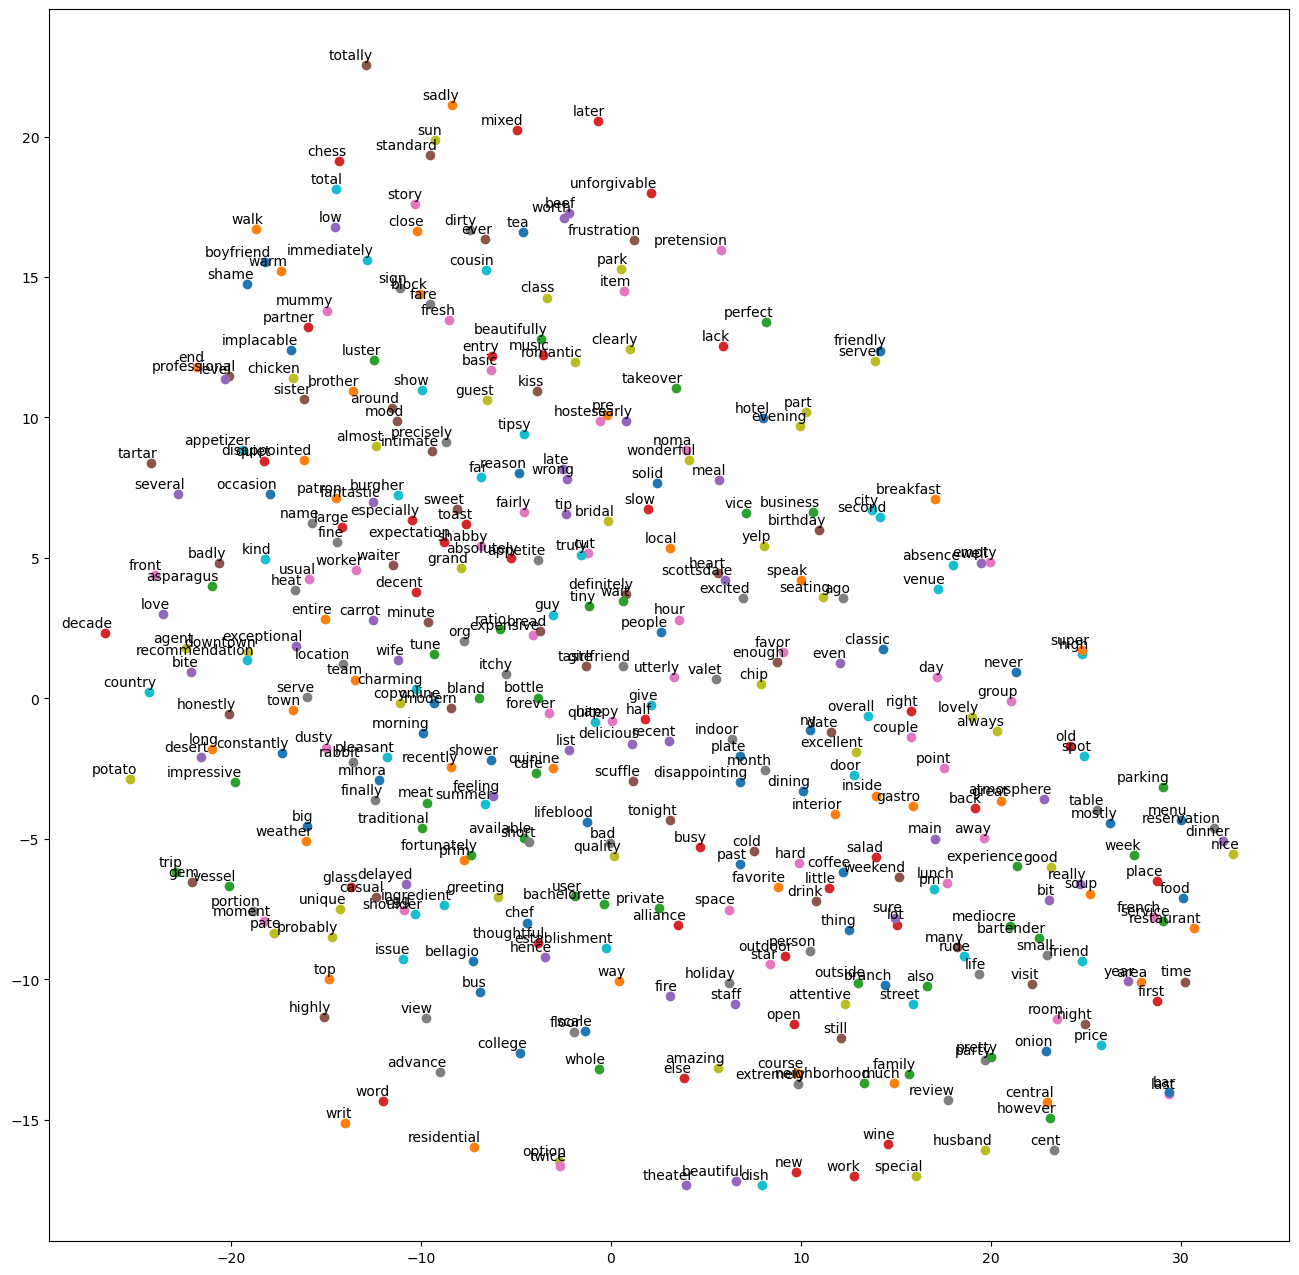

In [17]:
# We display a tsne plot of the word vectors
def tsne_plot(model):
    vocab = model.wv.index_to_key

    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        #print(tokens)
        #print(labels)
    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

tsne_plot(model)

com15: We can see from the plot that the model does not show great results for the similarity of words (and might explain our previous results). We believe that it was caused by our generation of words to fix the imbalance of our dataset. One way to fix this would be to start again and fix the imbalance by removing rows instead of generating rows (however we wanted to show our generation algorithm for the project). Therefore, we decided to proceed with a more suitable model, the GloVe model that we will see after our final analysis of our word2vec model.

### Using Tensorboard

com16: To look at the tensorboard results, you will need to download the VS tensorboard module or go to the corresponding port on your localhost (and making sure that the port is not used).
Please find the analysis of the tensorboard graphs on our powerpoint.

In [18]:
model = gensim.models.keyedvectors.KeyedVectors.load("word2vec.model")

max_size = len(model.wv.index_to_key)-1

# We initialise the 2D numpy array with 0s
w2v = np.zeros((max_size,model.vector_size))

# We create a folder to store the embeddings
word2vec_dir = 'projections/word2vec'
if not os.path.exists(word2vec_dir):
    os.makedirs(word2vec_dir)

# We store the words in a file called metadata.tsv
with open(f"{word2vec_dir}/metadata.tsv", 'w+') as file_metadata:
    
    # We write the first line with the number of words and the size of the embeddings
    for i, word in enumerate(model.wv.index_to_key[:max_size]):
        
        # We store the embeddings of the word
        w2v[i] = model.wv[word]
        
        # We write the word to the file 
        file_metadata.write(word + '\n')

# We create a TensorFlow variable initialised with the embeddings
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

# We use the Tensorflow variable scope to store the embeddings
with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

# We save the embeddings, the metadata, and the sprite images
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
writer = tf.compat.v1.summary.FileWriter(word2vec_dir, sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()

embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)
saver.save(sess, f'{word2vec_dir}/word2vec.ckpt', global_step=max_size)

2024-01-22 00:47:25.484739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-22 00:47:25.484771: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-22 00:47:25.484781: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-22 00:47:25.484822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 00:47:25.484840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-22 00:47:25.491327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


'projections/word2vec/word2vec.ckpt-366'

In [19]:
def semantic_search(query_word, model, topn=10):
    query_vector = model.wv[query_word]
    all_words = model.wv.index_to_key

    # We calculate cosine distance between query and all other words
    distances = {word: cosine(query_vector, model.wv[word]) for word in all_words}
    
    # We sort words by distance (lower is more similar)
    sorted_words = sorted(distances, key=distances.get)

    # We return the topn closest words
    return sorted_words[:topn]

# Example usage
search_results = semantic_search('wine', word2vec_model)

search_results

['wine',
 'area',
 'food',
 'place',
 'restaurant',
 'french',
 'time',
 'good',
 'nice',
 'parking']

com17: We carried this semantic search by first calculating the cosine distance between the query word and all other words in the vocabulary. We then sorted the words by distance (lower is more similar) and returned the top 10 closest words.

## TF-IDF

In [20]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(generated_df['cleaned_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, generated_df['sentiment'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

def classify_review(review_text):
    # Preprocess the review_text similar to your training data preprocessing
    preprocessed_text = preprocessing(review_text)  # Implement this function based on your preprocessing steps
    
    # Transform the review text to TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([preprocessed_text])
    
    # Predict the label
    predicted_label = classifier.predict(tfidf_features)
    
    return predicted_label

# Example usage
classify_review("This is a great restaurant! I loved the food and the service was amazing.")

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        93
           1       0.88      0.97      0.92       102
           2       0.97      0.84      0.90       117

    accuracy                           0.92       312
   macro avg       0.92      0.93      0.92       312
weighted avg       0.92      0.92      0.92       312



array([2])

com18: Seeing the results from our TF-IDF model, it is performing very well across all sentiment classes with high precision, recall, and F1-scores, and it shows a balanced performance across different sentiments. The example usage suggests that the model is effective in practical applications as well. In this case, the review generation proved useful.

In [21]:
from sklearn.pipeline import make_pipeline
import joblib

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))

# Fit the pipeline with your data
pipeline.fit(generated_df['cleaned_text'], generated_df['sentiment'])

# Save the pipeline
joblib.dump(pipeline, 'review_classification_pipeline.joblib')

['review_classification_pipeline.joblib']

com19: We create a pipeline to save our model and its calculations, in order to prevent losing computational time training it back in our streamlit application (which can be found in app.py)

## Tensorboard

In [22]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import tensorflow as tf
from tensorboard.plugins import projector

# Assuming X_tfidf is your TF-IDF matrix
svd = TruncatedSVD(n_components=50, random_state=42)  # Reduce to 50 dimensions
X_reduced = svd.fit_transform(X_tfidf)

# Create a projection directory
tfidf_dir = 'projections/tfidf'
if not os.path.exists(tfidf_dir):
    os.makedirs(tfidf_dir)
    
# Save the reduced embeddings and feature names
with open(f"{tfidf_dir}/metadata.tsv", 'w+') as file_metadata:
    # Use get_feature_names_out() for scikit-learn 0.24 and newer
    for feature_name in tfidf_vectorizer.get_feature_names_out():
        file_metadata.write(feature_name + '\n')

# TF-IDF embeddings after dimensionality reduction
tfidf_embeddings = np.array(X_reduced)

# Disable eager execution (needed for TensorBoard in TF1.x)
tf.compat.v1.disable_eager_execution()

# Start an interactive session
sess = tf.compat.v1.InteractiveSession()

# Create a TensorFlow variable for the embeddings
with tf.device("/cpu:0"):
    embedding_var = tf.Variable(tfidf_embeddings, trainable=False, name='tfidf_embedding')

# Initialize the variable
sess.run(tf.compat.v1.global_variables_initializer())

# Save the embeddings in a checkpoint
saver = tf.compat.v1.train.Saver([embedding_var])  # Add embedding_var to the saver
writer = tf.compat.v1.summary.FileWriter(tfidf_dir, sess.graph)

# Setup the projector configuration
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = 'metadata.tsv'

# Visualize embeddings
projector.visualize_embeddings(writer, config)
saver.save(sess, f'{tfidf_dir}/tfidf.ckpt')

2024-01-22 00:47:26.634885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 00:47:26.634905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'projections/tfidf/tfidf.ckpt'

## Our pre-trained GloVe model

com20: We carry out the same tasks and evaluations we did for the word2vec model we trained to compare their results and choose which would be the best option to use in our application's model.

In [23]:
model = api.load('glove-twitter-50') # We could have used the glove model too to get similar results. We chose to use the word2vec model because it was trained on our own data.

def vectorize_model(sent, model):
    vector_size = model.vector_size
    model_res = np.zeros(vector_size)
    ctr = 0
    for word in sent:
        if word in model.key_to_index:
            ctr += 1
            model_res += model[word]
    if ctr > 0:
        model_res = model_res / ctr
    return model_res

df['vectors'] = df['tokens'].apply(lambda x: vectorize_model(x, model))

X = df['vectors'].to_list()
y = df['sentiment'].to_list()

test_size = 0.3
stratify_value = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=stratify_value, random_state=42)

# Create a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC(kernel='linear')),
    ("Random Forest", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier())
]

# Loop through the classifiers and test each one
for name, classifier in classifiers:
    print(f"Testing {name} Classifier:")
    classifier.fit(X_train, y_train)  # We train the classifier on our data
    y_pred = classifier.predict(X_test)  # We make predictions on the test data

    # We evaluate the classifiers' performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

Testing Logistic Regression Classifier:
Accuracy: 0.7479

Testing SVM Classifier:
Accuracy: 0.7329

Testing Random Forest Classifier:


/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9765

Testing K-Nearest Neighbors Classifier:
Accuracy: 0.8098

Testing Decision Tree Classifier:
Accuracy: 0.9145



com21: We create our semantic search pipeline

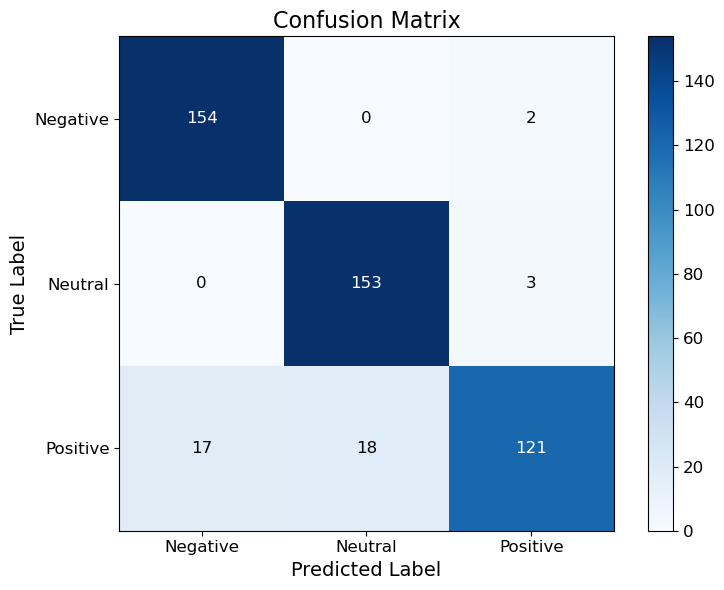

In [24]:
confusion = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap='Blues')

# Adding colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)

# Adding title and axis labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Customising tick labels
tick_labels = ['Negative', 'Neutral', 'Positive']
plt.xticks([0, 1, 2], tick_labels, fontsize=12)
plt.yticks([0, 1, 2], tick_labels, fontsize=12)

# Adding text annotations
thresh = confusion.max() / 2
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > thresh else "black",
                 fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()

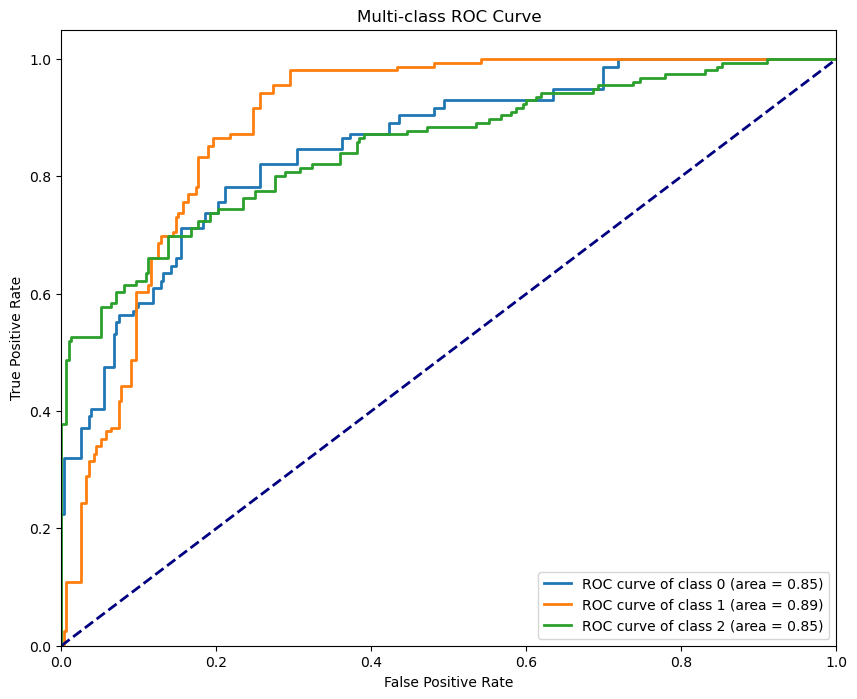

In [25]:
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Initialize classifier - using Logistic Regression as an example
# You can replace this with any classifier of your choice
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train, y_train_binarized)

# Predict probabilities
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each individual ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Retrieve the GloVe vocabulary and its vector size
glove_vocab = model.index_to_key
vector_size = model[glove_vocab[0]].shape[0]

# Set the maximum number of words to the size of the vocabulary
max_size = len(glove_vocab)

# Initialize the 2D numpy array with zeros
glove_embeddings = np.zeros((max_size, vector_size))

# Directory for GloVe embeddings
glove_dir = 'projections/glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Write the words to the metadata file
with open(f"{glove_dir}/metadata.tsv", 'w+') as file_metadata:
    for i, word in enumerate(glove_vocab):
        # Store the embeddings of the word
        glove_embeddings[i] = model[word]
        # Write the word to the file
        file_metadata.write(word + '\n')

# Disable eager execution for compatibility with TensorBoard
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

# Define the TensorFlow variable for the embeddings
with tf.device("/cpu:0"):
    embedding_var = tf.Variable(glove_embeddings, trainable=False, name='glove_embedding')

# Initialize the TensorFlow variable
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver([embedding_var])
writer = tf.compat.v1.summary.FileWriter(glove_dir, sess.graph)

# Configure the projector
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = 'metadata.tsv'

# Visualize the embeddings
projector.visualize_embeddings(writer, config)
saver.save(sess, f'{glove_dir}/glove.ckpt', global_step=max_size)

2024-01-22 00:47:56.832297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 00:47:56.832319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'projections/glove/glove.ckpt-1193514'

In [27]:
def semantic_search(query_word, model, topn=10):
    query_vector = model[query_word]
    all_words = model.index_to_key

    # We calculate cosine distance between query and all other words
    distances = {word: cosine(query_vector, model[word]) for word in all_words}
    
    # We sort words by distance (lower is more similar)
    sorted_words = sorted(distances, key=distances.get)

    # We return the topn closest words
    return sorted_words[:topn]

# Example usage
search_results = semantic_search('wine', model)

search_results

['wine',
 'beer',
 'coffee',
 'tea',
 'drinks',
 'drink',
 'bottle',
 'tasting',
 'drinking',
 'bath']

In [28]:
df

,restaurant_id,text,rating,location,business_name,business_price,business_review_count,business_display_address,business_display_phone,business_categories,cleaned_text,tokens,top_topic_labels,topics,sentiment,bigrams,trigrams,vectors
0,P6O50VeFlBIJpP0QPYsXbQ,We went for 2023 new years eve. I was hesit...,2,Las Vegas,Restaurant Guy Savoy,$$$$,459,"['3570 S Las Vegas Blvd', 'Caesars Palace', 'L...",(702) 731-7286,"[{'alias': 'french', 'title': 'French'}, {'ali...",we went for 2023 new years eve i was confident...,"[new, year, eve, resistant, almost, atrocious,...","[[family, restaurant, gastro, intimate, warm, ...","[Overall Experience, Venue & Occasions, Servic...",0,"[new_year, eve_resistant, almost_atrocious, ti...","[new_year, eve_resistant, almost_atrocious, ti...","[-0.1264911194642385, -0.09328500098652309, 0...."
1,l2b6HJGarUxoeLnM9syTmg,We had a very comfortable after dinner bottle ...,2,New York City,Compagnie des Vins Surnaturels,$$$,159,"['249 Ctr St', 'New York, NY 10013']",(212) 343-3660,"[{'alias': 'wine_bars', 'title': 'Wine Bars'},...",we had a very comfortable after dinner bottle ...,"[comfortable, dinner, bottle, wine, copy, fren...","[[wonderful, day, server, new, excited, fantas...","[Venue & Occasions, Culinary Selection, Dining...",2,"[comfortable, dinner, bottle, wine, copy, fren...","[comfortable, dinner, bottle, wine, copy, fren...","[-0.05628349787245194, 0.029864161585768063, 0..."
2,Pi-z6d8RrFPN8nLDOj4Bkg,The restaurant it's an amazing gem in river no...,2,Chicago,Marchesa,$$$,155,"['535 N Wells St', 'Chicago, IL 60654']",(312) 527-9535,"[{'alias': 'cocktailbars', 'title': 'Cocktail ...",the restaurant its an amazing gem in river nor...,"[restaurant, amazing, gem, river, north, roman...","[[restaurant, friend, excellent, night, staff,...","[Service Experience, Overall Experience, Celeb...",2,"[restaurant, amazing, gem, river, north, roman...","[restaurant, amazing, gem, river, north, roman...","[-0.12225849609822034, 0.042019692808389665, -..."
3,sQvMFqvQrdi2mnWkavf3tA,Special occasion family dinner. Ambience can n...,2,Los Angeles,Mistral,$$$,573,"['13422 Ventura Blvd', 'Sherman Oaks, CA 91423']",(818) 981-6650,"[{'alias': 'french', 'title': 'French'}, {'ali...",special occasion family dinner absence can not...,"[special, occasion, family, dinner, absence, l...","[[service, food, experience, amazing, great, d...","[Celebratory Events, Overall Experience, Servi...",2,"[special_occasion, family, dinner, absence, lo...","[special_occasion, family, dinner, absence, lo...","[-0.140977557334635, -0.023323665890428755, -0..."
4,Pm2XIvuYeOXa_FxoGdMEQg,Never suggest this restaurant to anybody. \nI ...,0,Los Angeles,208 Rodeo,$$$,1146,"['208 N Rodeo Dr', 'Beverly Hills, CA 90210']",(310) 275-2428,"[{'alias': 'newamerican', 'title': 'New Americ...",never suggest anything one so god they wish th...,"[never, restaurant, star, busy, husband, resta...","[[restaurant, friend, excellent, night, staff,...","[Service Experience, Culinary Selection, Overa...",0,"[never, restaurant, star, busy, husband, resta...","[never, restaurant, star, busy, husband, resta...","[-0.012364281075341361, 0.3412814289331436, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,iP7lliKwBV52eHkqPinMiA,"Disappointing. There is nowhere to park, no va...",0,Houston,Brasserie du Parc,$$$,369,"['1440 Lamar St', 'Houston, TX 77010']",(832) 879-2802,"[{'alias': 'brasseries', 'title': 'Brasseries'...",but there is nowhere the park no valet no taxe...,"[nowhere, valet, garage, away, place, mostly, ...","[[good, food, dinner, french, place, really, t...","[Dining Atmosphere, Culinary Selection, Servic...",0,"[nowhere_valet, garage_away, place_mostly, emp...","[nowhere_valet, garage_away, place_mostly, emp...","[-0.007250826805830002, -0.21747241790095964, ..."
1554,lq1MXuvw45E9SfpQL-LMgw,We were very excited to come here. When we arr...,0,Los Angeles,Tesse Restaurant,$$$,666,"['8500 W Sunset Blvd', 'Ste B', 'West 

In [31]:
from scipy import spatial

def review_to_vector(review, model):
    words = review.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def semantic_search(query, model, reviews):
    query_vector = review_to_vector(query, model)

    # Calculate similarity between query and each review
    similarities = []
    
    restaurant_set = set()

    for review in reviews:
        review_vector = review_to_vector(review, model)
        similarity = 1 - spatial.distance.cosine(query_vector, review_vector)

        row = df[df['cleaned_text'] == review]
        restaurant_id = row['restaurant_id'].values[0]
        
        if restaurant_id not in restaurant_set:
            similarities.append((review, similarity))
            restaurant_set.add(restaurant_id)
            
    # Sort reviews by similarity
    sorted_reviews = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Return the topn most similar reviews
    return sorted_reviews

user_query = "I wish to eat a steak"

semantic_search(user_query, model, df['cleaned_text'].tolist())

[('what i ordered\n\n710 french onion soup  22\n a little too salt\n bread and gruyère comb was mummy\n they split this for us to share \n even a half',
  0.9540849924087524),
 ('i happened by here a well but never went inside until this past weekend called a friend or got the french onion soup and a salad i or a minora and eggs',
  0.9459344744682312),
 ('eh grand sat by the bar knowing i could at least get a clean wine but it went bad instantly when some bartender poured me some without i having actually',
  0.9379290342330933),
 ('beer gabriel kreuther is called one after the name behind this restaurant offering like 3 or 8 alsatian wasting menu water and dinner menu as well as a',
  0.9379144310951233),
 ('we came here one night for a friends birthday and it was unique experience make reservations get a sit down table order some appetisers and food drinks',
  0.9366233944892883),
 ('good menu mummy food and service friendly and attentive pretty solid value for what you get with a s